# Generating Weekday and Weekend profiles

In [10]:
import polars as pl
import glob
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import logging
from tslearn.clustering import TimeSeriesKMeans 
import re
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

logging.getLogger('matplotlib.font_manager').disabled = True

from validation import validation

## Weekday Clustering-->Difference between weekday and weekend

In [11]:
input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_weekday_normalized")

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

n_timestamps = 96

data_list = []
filename_list = []

pattern = re.compile(r"(CH[^_\.]*)")  # Matches 'CH' followed by any chars except _ or .

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)
        
        base = os.path.basename(file_path)
        match = pattern.search(base)
        if match:
            filename_list.append(match.group(1))
        else:
            filename_list.append(base)  # fallback to full basename if no CH... found

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")

print(filename_list[:10])  # Preview first 10 extracted CH... names

train_data_weekday = data_3d

Shape of the 3D array: (1464, 96, 1)
['CH1018601234500000000000000040851', 'CH1018601234500000000000000047828', 'CH1018601234500000000000000112970', 'CH1018601234500000000000000076787', 'CH1018601234500000000000000067786', 'CH1018601234500000000000000036798', 'CH1018601234500000000000000065363', 'CH1018601234500000000000000065862', 'CH1018601234500000000000000024655', 'CH1018601234500000000000000070197']


In [12]:
n_clusters = 4  # Number of clusters, you can adjust this
max_iterations =100

kmeans = TimeSeriesKMeans(n_clusters=n_clusters,max_iter=max_iterations, verbose=True, random_state=42, n_jobs=-1)
clusters_train_weekday = kmeans.fit_predict(train_data_weekday)



3.474 --> 2.466 --> 2.357 --> 2.325 --> 2.309 --> 2.298 --> 2.289 --> 2.284 --> 2.282 --> 2.280 --> 2.278 --> 2.277 --> 2.277 --> 2.277 --> 2.277 --> 2.277 --> 2.277 --> 2.277 --> 


In [13]:
print(clusters_train_weekday)

remap = {2: 0, 1: 1, 3: 2, 0: 3} #weekday
clusters_train_weekday = np.vectorize(remap.get)(clusters_train_weekday)

print(clusters_train_weekday)

[1 1 2 ... 1 1 1]
[1 1 0 ... 1 1 1]


In [14]:
input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_weekend_normalized")

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

n_timestamps = 96

data_list = []
filename_list = []

pattern = re.compile(r"(CH[^_\.]*)")  # Matches 'CH' followed by any chars except _ or .

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)
        
        base = os.path.basename(file_path)
        match = pattern.search(base)
        if match:
            filename_list.append(match.group(1))
        else:
            filename_list.append(base)  # fallback to full basename if no CH... found

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")

print(filename_list[:10])  # Preview first 10 extracted CH... names

train_data_weekend = data_3d

Shape of the 3D array: (1464, 96, 1)
['CH1018601234500000000000000040851', 'CH1018601234500000000000000047828', 'CH1018601234500000000000000112970', 'CH1018601234500000000000000076787', 'CH1018601234500000000000000067786', 'CH1018601234500000000000000036798', 'CH1018601234500000000000000065363', 'CH1018601234500000000000000065862', 'CH1018601234500000000000000024655', 'CH1018601234500000000000000070197']


In [15]:
n_clusters = 4  # Number of clusters, you can adjust this
max_iterations =100

kmeans = TimeSeriesKMeans(n_clusters=n_clusters,max_iter=max_iterations, verbose=True, random_state=42, n_jobs=-1)
clusters_train_weekend = kmeans.fit_predict(train_data_weekend)



3.943 --> 2.439 --> 2.317 --> 2.278 --> 2.260 --> 2.252 --> 2.250 --> 2.249 --> 2.249 --> 2.247 --> 2.247 --> 2.247 --> 2.247 --> 2.247 --> 2.247 --> 2.247 --> 2.247 --> 


In [17]:
print(clusters_train_weekend)

remap = {1: 0, 0: 1, 3: 2, 2: 3} #weekend
clusters_train_weekend = np.vectorize(remap.get)(clusters_train_weekend)

print(clusters_train_weekend)

[0 0 1 ... 0 0 1]
[1 1 0 ... 1 1 0]


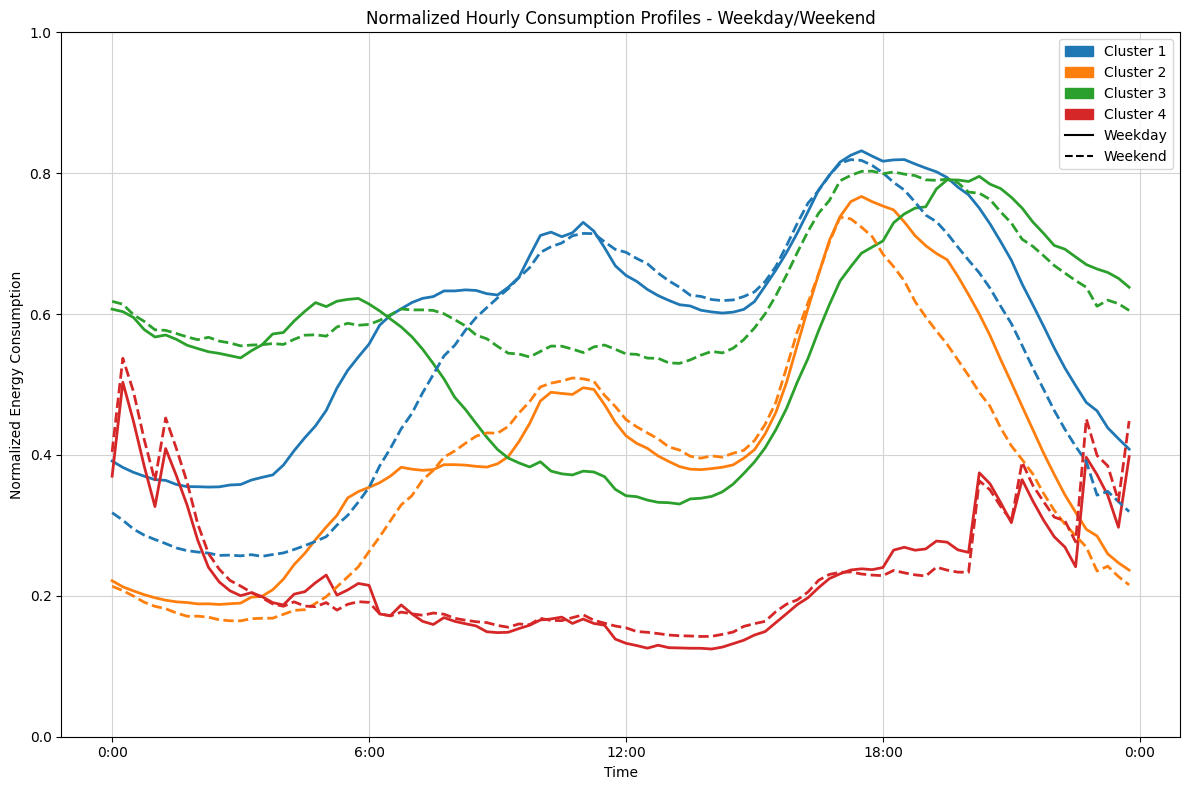

In [19]:

labels = ['0:00','6:00','12:00','18:00','0:00']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd']
color_patches = [mpatches.Patch(color=colors[i], label=f'Cluster {i+1}') for i in range(n_clusters)]

def plot_clusters_season():
    plt.figure(figsize=(12,8))

    # First: plot solid lines (set 1)
    for cluster_idx in range(n_clusters):
        cluster_data_weekday = train_data_weekday[clusters_train_weekday == cluster_idx]
        mean_time_series = np.mean(cluster_data_weekday, axis=0)
        plt.plot(range(1,97), mean_time_series.ravel(), 
                label= f'Cluster {cluster_idx+1} (Set 1)',
                linewidth=2, color=colors[cluster_idx], linestyle='solid')

    # Second: plot dashed lines (set 2)
    for cluster_idx in range(n_clusters):
        cluster_data_weekend = train_data_weekend[clusters_train_weekend == cluster_idx]
        mean_time_series_2 = np.mean(cluster_data_weekend, axis=0)
        plt.plot(range(1,97), mean_time_series_2.ravel(), 
                label= f'Cluster {cluster_idx+1} (Set 2)',
                linewidth=2, color=colors[cluster_idx], linestyle='dashed')

    plt.title(f'Normalized Hourly Consumption Profiles - Weekday/Weekend')
    plt.xlabel("Time")
    plt.ylabel("Normalized Energy Consumption")
    plt.ylim(0,1)
    plt.xticks(range(1,120,24),labels=labels)
    plt.tight_layout()
    plt.grid(True, color = 'lightgray')
    
    solid_line = mlines.Line2D([], [], color='black', linestyle='solid', label='Weekday')
    dashed_line = mlines.Line2D([], [], color='black', linestyle='dashed', label='Weekend')


    plt.legend(handles=color_patches + [solid_line, dashed_line], loc='upper right', fontsize='medium')

    plt.savefig(
        "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/Plots/Cluster/clusters_weekday_weekend.png",
        bbox_inches='tight'
    )
    plt.show()

plot_clusters_season()